In [2]:
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split

In [3]:
# Função para carregar imagens de um diretório e redimensionar
def load_images_from_folder(folder, img_size, labels_dict=None, max_images=None, sort=False):
    images = []
    labels = []

    file_list = os.listdir(folder)
    # Ordenar os arquivos numericamente (por conta do submission file)
    if sort:
        file_list = sorted(file_list, key=lambda x: int(x.split('.')[0]))

    for filename in file_list:
        if max_images and len(images) >= max_images:
            break
        if filename.endswith(".jpg"):
            img_path = os.path.join(folder, filename)
            img = Image.open(img_path).resize((img_size, img_size)).convert('RGB')
            img_array = np.array(img)
            images.append(img_array)
            # Etiquetar as imagens: 0 para gato, 1 para cachorro
            if labels_dict:
                labels.append(labels_dict[filename])
            elif 'cat' in filename:
                labels.append('cat')
            elif 'dog' in filename:
                labels.append('dog')
    return np.array(images), np.array(labels)

In [6]:
train_folder = './train'
submission_folder = './samples'
img_size = 64  # Redimensionar imagens para 64x64 pixels

# Carregar imagens de treino
X_train, y_train = load_images_from_folder(train_folder, img_size)

# Para o conjunto de teste, podemos simplesmente carregar as imagens sem etiquetas
# ou usar um conjunto de validação a partir dos dados de treinamento
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

X_submission, _ = load_images_from_folder(submission_folder, img_size, sort=True)

In [7]:
import matplotlib.pyplot as plt

# Função para detectar imagens corrompidas
def detect_corrupted_images(folder):
    corrupted_files = []
    for filename in os.listdir(folder):
        if filename.endswith(".jpg"):
            try:
                img = Image.open(os.path.join(folder, filename))
                img.verify()  # Verificar a integridade do arquivo
            except (IOError, SyntaxError) as e:
                corrupted_files.append(filename)
    return corrupted_files

# Detectar imagens corrompidas
corrupted_train_images = detect_corrupted_images(train_folder)
print(f"Imagens corrompidas no conjunto de treino: {corrupted_train_images}")

corrupted_submission_images = detect_corrupted_images(submission_folder)
print(f"Imagens corrompidas no conjunto de submissão: {corrupted_submission_images}")

Imagens corrompidas no conjunto de treino: []
Imagens corrompidas no conjunto de submissão: []


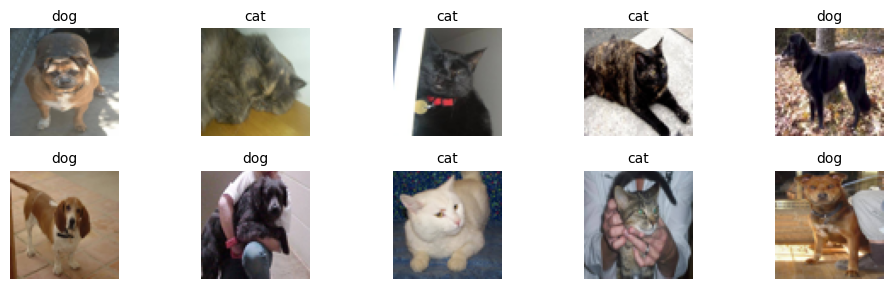

In [10]:
import random

plt.figure(figsize=(10, 3))
for i in range(10):
  rnd = random.randint(0, len(X_train))
  image = X_train[rnd]
  true_label = y_train[rnd]

  plt.subplot(2, 5, i + 1)
  plt.imshow(image, cmap='gray')
  plt.title(f'{true_label}', fontsize=10)
  plt.axis('off')
plt.tight_layout()
plt.show()

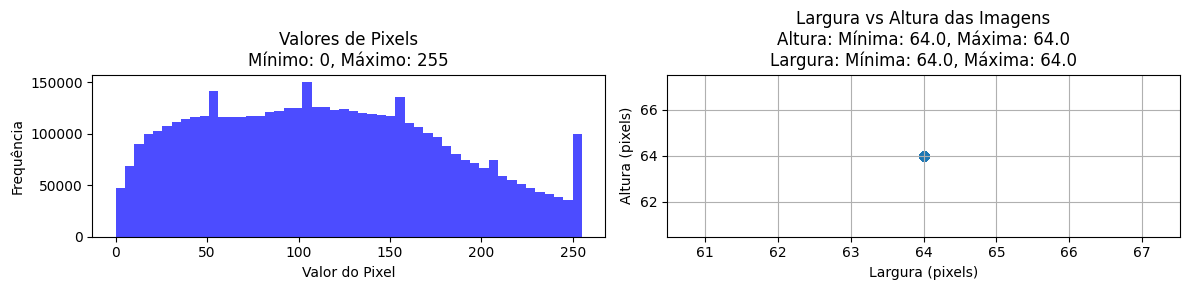

In [13]:
# Base de Submissão
# Obter valores mínimos e máximos dos pixels
pixel_min = np.min(X_submission)
pixel_max = np.max(X_submission)

# Obter dimensões das imagens
image_heights = X_submission.shape[1] * np.ones(X_submission.shape[0])
image_widths = X_submission.shape[2] * np.ones(X_submission.shape[0])

# Plotar valores mínimos e máximos dos pixels
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.hist(X_submission.flatten(), bins=50, color='blue', alpha=0.7)
plt.title(f'Valores de Pixels\nMínimo: {pixel_min}, Máximo: {pixel_max}')
plt.xlabel('Valor do Pixel')
plt.ylabel('Frequência')

# Plotar gráfico de dispersão de largura vs altura
plt.subplot(1, 2, 2)
plt.scatter(image_widths, image_heights, alpha=0.5)
plt.title(f'Largura vs Altura das Imagens\nAltura: Mínima: {image_heights.min()}, Máxima: {image_heights.max()}\nLargura: Mínima: {image_widths.min()}, Máxima: {image_widths.max()}')
plt.xlabel('Largura (pixels)')
plt.ylabel('Altura (pixels)')
plt.grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Normalizar os dados
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0
X_submission = X_submission.astype('float32') / 255.0

In [15]:
# Verificar formas dos dados carregados
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')
print(f'X_submission shape: {X_submission.shape}')

X_train shape: (20000, 64, 64, 3)
y_train shape: (20000,)
X_test shape: (5000, 64, 64, 3)
y_test shape: (5000,)
X_submission shape: (400, 64, 64, 3)


In [17]:
train_unique_values, train_counts = np.unique(y_train, return_counts=True)
print("Valores únicos:", train_unique_values)
print("Contagens:", train_counts)

Valores únicos: ['cat' 'dog']
Contagens: [ 9988 10012]


In [18]:
X_train_flat = X_train.reshape((X_train.shape[0], -1))
X_test_flat = X_test.reshape((X_test.shape[0], -1))
X_submission_flat = X_submission.reshape((X_submission.shape[0], -1))

print(X_train_flat.shape)
print(X_test_flat.shape)
print(X_submission_flat.shape)

(20000, 12288)
(5000, 12288)
(400, 12288)


In [19]:
from sklearn.decomposition import PCA

n_components = 500
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_flat)
X_test_pca = pca.transform(X_test_flat)
X_submission_pca = pca.transform(X_submission_flat)

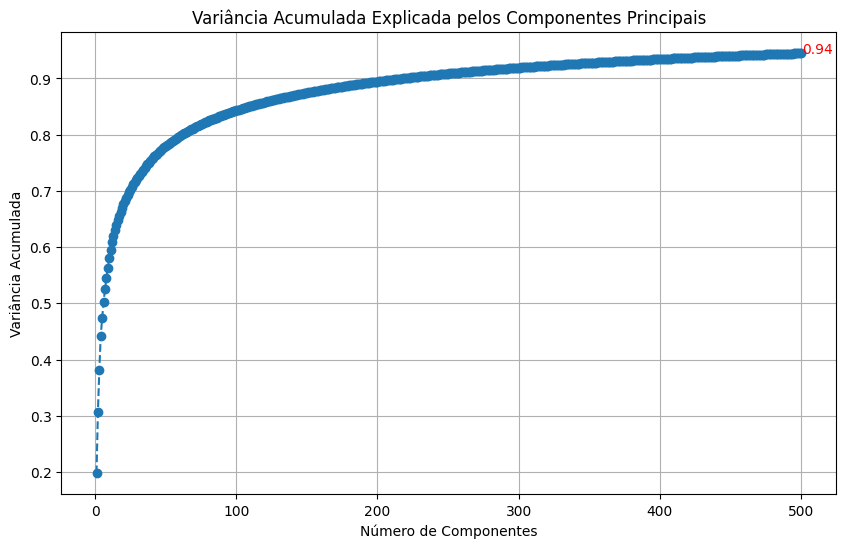

In [20]:
# Plotar variância acumulada
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_variance, marker='o', linestyle='--')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Acumulada')
plt.title('Variância Acumulada Explicada pelos Componentes Principais')
plt.annotate("{:.2f}".format(cumulative_variance[-1]), xy=(n_components+1, cumulative_variance[-1]), color='red')
plt.grid(True)

In [21]:
from sklearn.linear_model import LogisticRegression
# Treinamento de um modelo Regressão Logistica
def train(X_train, y_train):
  model = LogisticRegression(max_iter=10000)
  model.fit(X_train, y_train)
  return model

model = train(X_train_pca, y_train)

In [22]:
X_train_pca.shape

(20000, 500)

Resultados de Treino
Acurácia: 0.6488
F1 score: 0.6487866258845877


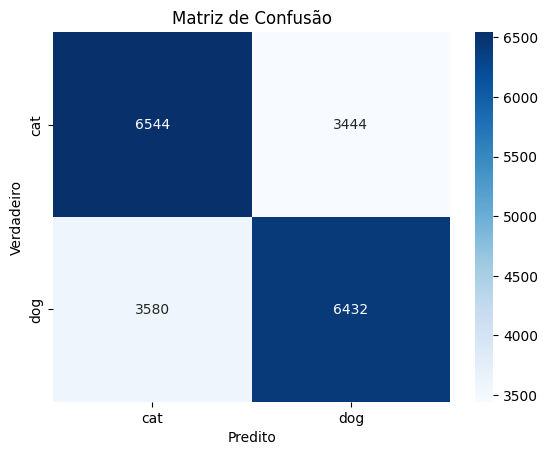

Resultados de Teste
Acurácia: 0.6006
F1 score: 0.6004260699068381


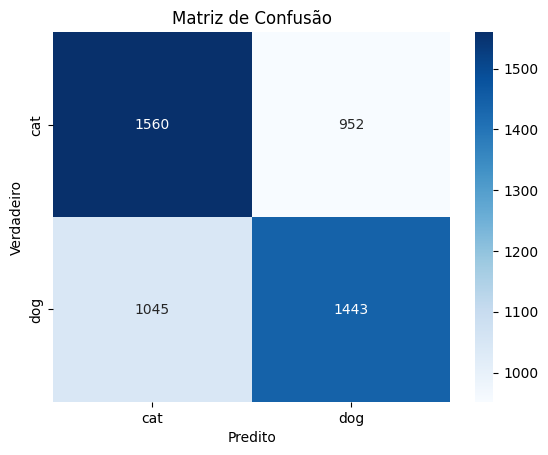

In [24]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, confusion_matrix
import seaborn as sns

# Inferência e avaliação
def predict_and_evaluate(model, X_test, y_test):

    # Inferência
    y_pred = model.predict(X_test)

    # Métricas
    print('Acurácia:', accuracy_score(y_test, y_pred))
    print('F1 score:', f1_score(y_test, y_pred, average='weighted'))

    # Matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)

    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Verdadeiro')
    plt.show()

print('Resultados de Treino')
predict_and_evaluate(model, X_train_pca, y_train)
print('Resultados de Teste')
predict_and_evaluate(model, X_test_pca, y_test)

In [26]:
from skimage.feature import hog
# Extração de características utilizando HOG
def extract_hog_features(images):
    hog_features = []
    hog_images = []
    for image in images:
        features, img = hog(image, orientations=9,      # o número de direções angulares distintas para as quais os gradientes são calculados
                              pixels_per_cell=(8, 8),   # tamanho (em pixels) de cada célula na qual a imagem é dividida para calcular o histograma de gradientes orientados
                              cells_per_block=(2, 2),   # número de células em cada bloco. Os blocos são usados para normalizar os histogramas de gradientes dentro de células, melhorando a robustez a variações de iluminação e contraste.
                              visualize=True,           # se a imagem HOG (uma representação visual das características HOG) deve ser retornada junto com o vetor de características.
                              channel_axis=-1)          # índice do eixo do canal na imagem de entrada.
        hog_features.append(features)
        hog_images.append(img)
    return np.array(hog_features), hog_images

# Extraindo características HOG dos dados de treinamento e teste
X_train_hog, train_hog_images = extract_hog_features(X_train)
X_test_hog, _ = extract_hog_features(X_test)
X_submission_hog, _ = extract_hog_features(X_submission)

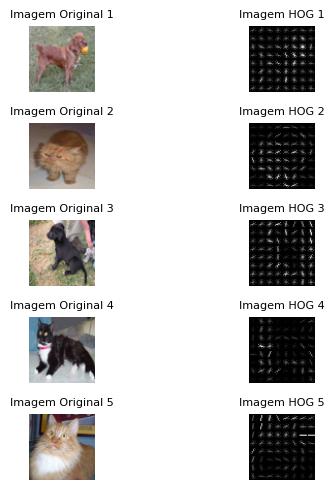

In [27]:
# Visualizar imagens HOG
def visualize_multiple_hog(images, hog_images, images_to_show=5):
    plt.figure(figsize=(6, images_to_show))

    for i in range(images_to_show):
        # Mostrar imagem original
        plt.subplot(images_to_show, 2, 2 * i + 1)
        plt.imshow(images[i], cmap='gray', vmin=0, vmax=1)
        plt.title(f'Imagem Original {i+1}', fontsize=8)
        plt.axis('off')

        # Mostrar imagem HOG
        plt.subplot(images_to_show, 2, 2 * i + 2)
        plt.imshow(hog_images[i], cmap='gray')
        plt.title(f'Imagem HOG {i+1}', fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Exemplo de visualização das primeiras n imagens do conjunto de treinamento
images_to_show = 5
visualize_multiple_hog(X_train, train_hog_images, images_to_show=images_to_show)

In [28]:
# Atributos extraídos
X_train_hog.shape

(20000, 1764)

Resultados de Treino
Acurácia: 0.7677
F1 score: 0.7676840792199151


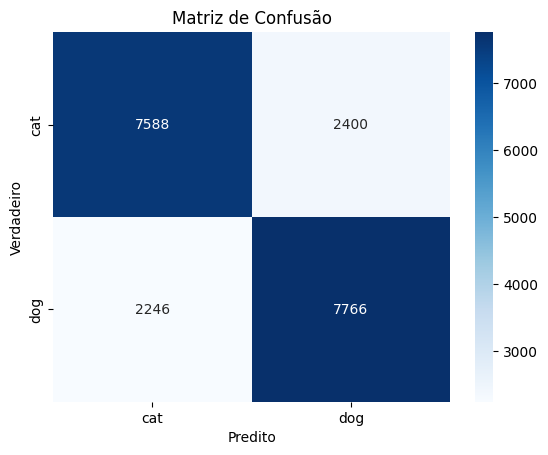

Resultados de Teste
Acurácia: 0.7378
F1 score: 0.7377360431799134


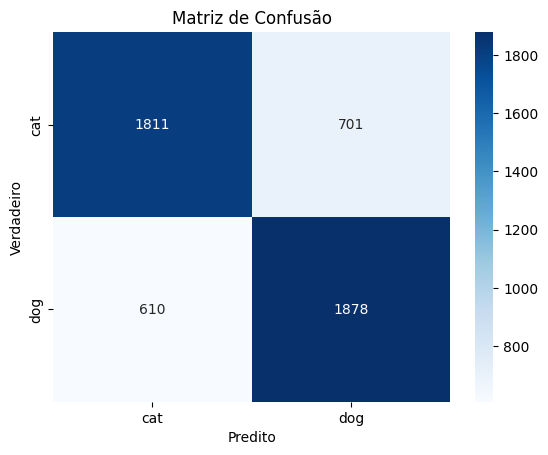

In [29]:
model = train(X_train_hog, y_train)

print('Resultados de Treino')
predict_and_evaluate(model, X_train_hog, y_train)
print('Resultados de Teste')
predict_and_evaluate(model, X_test_hog, y_test)

# Exercício: Concatene os componentes principais e as features extraídas com HOG e treine novamente o modelo

In [30]:
print(X_train_hog.shape)
print(X_train_pca.shape)

(20000, 1764)
(20000, 500)


In [31]:
# Concatenar as características HOG e PCA
X_train_concat = np.hstack((X_train_hog, X_train_pca))
X_test_concat = np.hstack((X_test_hog, X_test_pca))
X_submission_concat = np.hstack((X_submission_hog, X_submission_pca))

In [32]:
print(X_train_concat.shape)

(20000, 2264)


Resultados de Treino
Acurácia: 0.7929
F1 score: 0.7928951019368337


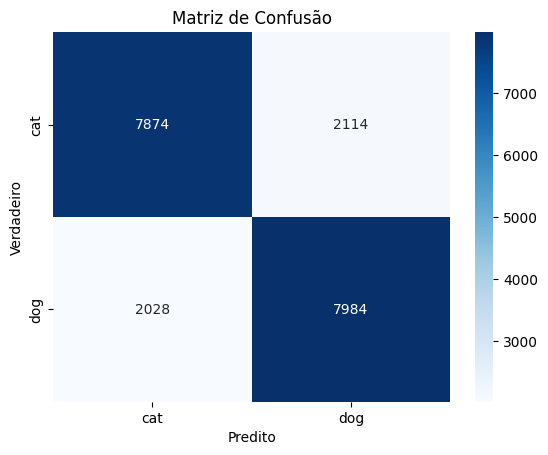

Resultados de Teste
Acurácia: 0.7428
F1 score: 0.7427833328399822


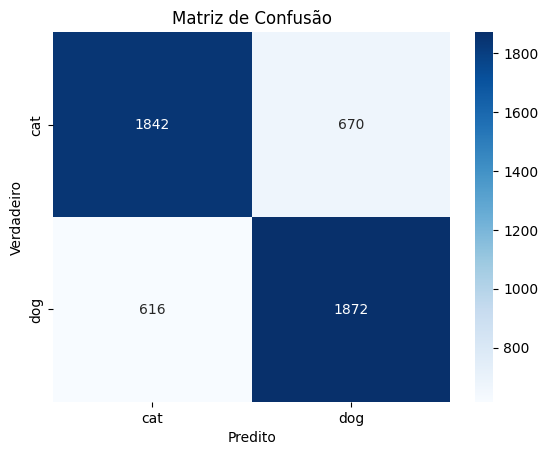

In [33]:
model = train(X_train_concat, y_train)

print('Resultados de Treino')
predict_and_evaluate(model, X_train_concat, y_train)
print('Resultados de Teste')
predict_and_evaluate(model, X_test_concat, y_test)

# Exercício: Inferir imagens para submissão no kaggle

In [34]:
y_pred = model.predict(X_submission_concat)

In [35]:
import pandas as pd
results = pd.DataFrame()
results['id'] = list(range(1, y_pred.shape[0] + 1))
results['label'] = y_pred
results.head()

,id,label
0,1,cat
1,2,dog
2,3,dog
3,4,dog
4,5,dog


In [39]:
import pandas as pd
from datetime import datetime

# Generate the current timestamp
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M')

# Generate the file name with the timestamp
file_name = f'results_{timestamp}.csv'

# Save the DataFrame to a CSV file
results.to_csv(file_name, index=False)

# Display the first few rows of the DataFrame
results.head()


,id,label
0,1,cat
1,2,dog
2,3,dog
3,4,dog
4,5,dog
